In [1]:
import os
import re

from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from jaref_bot.data.http_api import ExchangeManager, BybitRestAPI
from jaref_bot.utils.files import load_tokens_from_file
from jaref_bot.utils.coinmarketcap import get_top_tokens
from jaref_bot.db.postgres_manager import DBManager
from jaref_bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

import pandas as pd
# pd.options.display.float_format = '{:.2f}'.format

import polars as pl
import polars_ols as pls

import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [2]:
def sort_pairs(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin1")).otherwise(pl.col("coin2")).alias("pair_min"),
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin2")).otherwise(pl.col("coin1")).alias("pair_max"),
    ]).drop('coin1', 'coin2').rename({'pair_min': 'coin1', 'pair_max': 'coin2'}).select('coin1', 'coin2', pl.exclude('coin1', 'coin2'))

In [3]:
# get_top_tokens(limit=1000, output_file='./jaref_bot/config/top_1000_tokens.txt')

#### Скачиваем данные с Bybit

In [4]:
async def get_data(symbol, interval, n_iters):
    df = await exc_manager.get_candles(symbol=symbol, interval=interval, n_iters=n_iters)
    df = df['bybit_linear'].sort_index()
    df['Returns'] = df['Close'].pct_change()
    df['Log_price'] = np.log(df['Close'] + 1)
    df['Log_returns'] = np.log(df['Returns'] + 1)
    return df.dropna()

In [5]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

In [6]:
res = await get_data(symbol='ADA_USDT', interval='1h', n_iters=1)
res.shape

(999, 11)

In [7]:
top_1000_tokens = load_tokens_from_file("./jaref_bot/config/top_1000_tokens.txt")
tokens_to_del = ['USDT', 'USDC', 'LEO', 'USDe']
token_list = [x + '_USDT' for x in top_1000_tokens if x not in tokens_to_del]

In [8]:
prices = await exc_manager.get_prices()
prices = prices['bybit_linear']
len(prices)

557

In [9]:
current_tokens = ['1INCH_USDT', 'AI16Z_USDT', 'APT_USDT', 'ARB_USDT', 'ARKM_USDT',
              'BLUR_USDT',
              'CELO_USDT', 'CHZ_USDT', 'CRV_USDT', 'CVX_USDT',
              'DOT_USDT', 'DYDX_USDT', 'FIL_USDT', 'FLOW_USDT',
              'GALA_USDT', 'GMT_USDT', 'GRT_USDT', 'JASMY_USDT',
              'IMX_USDT', 'IOTA_USDT', 'KAS_USDT', 'KSM_USDT',
              'LDO_USDT',
              'MANA_USDT', 'MANTA_USDT', 'MORPHO_USDT', 'MOVE_USDT', 'NEAR_USDT',
              'ONDO_USDT', 'OP_USDT', 'ORDI_USDT',
              'POL_USDT', 'RENDER_USDT', 'ROSE_USDT',
              'SAND_USDT', 'SEI_USDT', 'STRK_USDT',
              'STX_USDT', 'SUI_USDT', 'SUSHI_USDT',
              'TIA_USDT', 'VET_USDT', 'XRP_USDT',
              'ZEN_USDT', 'ZK_USDT']
len(current_tokens)

45

In [10]:
# Настройки параметров
interval = '1d'
n_iters = 1
start_date = datetime(2025, 5, 1, tzinfo=ZoneInfo("Europe/Moscow"))
end_date = datetime(2025, 11, 1, tzinfo=ZoneInfo("Europe/Moscow"))
min_volume = 1_000_000
days_ago = 20 # За сколько последних дней смотреть волатильность
max_volatility = 45

In [11]:
main_df = pd.DataFrame()

token_dict = {'PEPE_USDT': '1000PEPE_USDT', 'SHIB_USDT': 'SHIB1000_USDT', 'FLOKI_USDT': '1000FLOKI_USDT',
             'BONK_USDT': '1000BONK_USDT', 'BTT_USDT': '1000BTT_USDT', 'XEC_USDT': '1000XEC_USDT',
             'LUNC_USDT': '1000LUNC_USDT', 'SATS_USDT': '10000SATS_USDT', 'TURBO_USDT': '1000TURBO_USDT',
             'CAT_USDT': '1000CAT_USDT'}
bad_tokens = []

for token in tqdm(current_tokens):
    df = await get_data(symbol=token, interval=interval, n_iters=n_iters)
    df = df.reset_index()

    if df.empty:
        continue 

    row = df[df['Date'].dt.date == (end_date - timedelta(days=2)).date()]
    vol24 = row['Turnover'].item() # Берём предпоследнюю запись, потому что последний день будет половинчатым
    if vol24 < min_volume:
        if token in current_tokens:
            print(f'{token} недостаточно торгового объёма ({int(vol24):_})')
            bad_tokens.append(token)
        continue
    
    df = df[(df['Date'] > start_date) & (df['Date'] < end_date)]

    if df.empty:
        continue
        
    # first_date = df['Date'].head(1).item().floor('D')
    # last_date = df['Date'].tail(1).item().floor('D')
    
    # if first_date > pd.Timestamp('2025-05-10', tz='Europe/Moscow'):
    #     continue
    # if last_date < pd.Timestamp('2025-10-25', tz='Europe/Moscow'):
    #     continue

    df = df.set_index('Date')
    daily_df = df[-days_ago:]
    daily_df['Max_range'] = daily_df['High'] - daily_df['Low']
    daily_df['Max_range_perc'] = (daily_df['High'] - daily_df['Low']) / daily_df['Low'] * 100

    if daily_df['Max_range_perc'].max() > max_volatility:
        if token in current_tokens:
            print(f'{token} высокая волатильность: {daily_df['Max_range_perc'].max():.1f}%')
            bad_tokens.append(token)
        continue

    main_df[f'{token[:-5]}_price'] = df['Close']
    main_df[f'{token[:-5]}_log_returns'] = df['Log_returns']
    main_df[f'{token[:-5]}_log_price'] = df['Log_price']

  0%|          | 0/45 [00:00<?, ?it/s]

AI16Z_USDT высокая волатильность: 54.8%


In [12]:
len(current_tokens), len(bad_tokens)

(45, 1)

In [13]:
[current_tokens.remove(token) for token in bad_tokens]
len(current_tokens)

44

#### Distance approach

In [14]:
from jaref_bot.utils.data import make_price_df_from_orderbooks_bulk, normalize
import itertools
import math

In [15]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [16]:
# Создадим список из датафреймов для удобства пакетной обработки, а также получим кол-во знаков после запятой для округления
max_days = 180 # За сколько дней считать расстояние
tokens = [x[:-5] for x in current_tokens]
dfs = []
token_dp = {}

for token in tokens:
    try:
        df_token = main_df[[f'{token}_price']].rename(columns={f'{token}_price': 'price'})
        df_token['token'] = token
        df_token = pl.from_pandas(df_token, include_index=True).rename({'Date': 'time'}).tail(max_days)
    except KeyError:
        continue
    
    try:
        dp = coin_information['bybit_linear'][token + '_USDT']['qty_step']
    except IndexError:
        dp = 0

    token_dp[token] = dp
    dfs.append(df_token)

In [17]:
price_df = make_price_df_from_orderbooks_bulk(dfs=dfs, tokens=tokens, trunc='5m')
curr_prices = price_df.drop('time').tail(1).transpose(include_header=True, header_name='coin', column_names=['price'])
price_df.tail(1)

time,1INCH,APT,ARB,ARKM,BLUR,CELO,CHZ,CRV,CVX,DOT,DYDX,FIL,FLOW,GALA,GMT,GRT,JASMY,IMX,IOTA,KAS,KSM,LDO,MANA,MANTA,MORPHO,MOVE,NEAR,ONDO,OP,ORDI,POL,RENDER,ROSE,SAND,SEI,STRK,STX,SUI,SUSHI,TIA,VET,XRP,ZEN,ZK
"datetime[ns, Europe/Moscow]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-10-31 03:00:00 MSK,0.1619,3.255,0.2951,0.3261,0.04627,0.236,0.03084,0.4795,2.201,2.8796,0.2955,1.514,0.2602,0.01005,0.02437,0.06134,0.009972,0.4934,0.1373,0.05278,9.45,0.8714,0.2267,0.0987,1.9569,0.06729,2.096,0.6866,0.3987,4.637,0.184,2.228,0.01496,0.2018,0.1905,0.103,0.4127,2.3621,0.488,0.899,0.01558,2.508,14.529,0.02884


In [18]:
price_df.shape, price_df.drop_nans().shape

((180, 45), (180, 45))

In [19]:
normed_df = normalize(df=price_df, method='minimax', shift_to_zero=False)

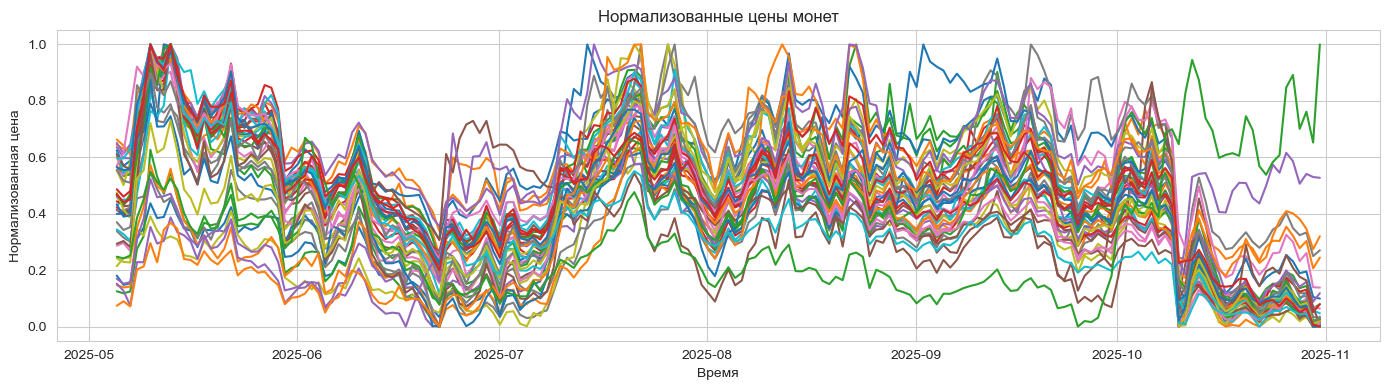

In [20]:
# Нарисуем график с нормализованными ценами
price_cols = [c for c in normed_df.columns if c != 'time']

plt.figure(figsize=(14, 4))
for col in price_cols:
    plt.plot(normed_df['time'].to_list(), normed_df[col].to_list(), label=col)

plt.xlabel("Время")
plt.ylabel("Нормализованная цена")
plt.title("Нормализованные цены монет")
plt.grid(True)
plt.tight_layout()

In [21]:
# Посчитаем евклидово расстояние между парами криптовалют
results = []

# Перебираем все уникальные пары колонок
for col1, col2 in itertools.combinations(price_cols, 2):
    diff_sq = (normed_df[col1] - normed_df[col2]) ** 2
    distance = math.sqrt(diff_sq.sum())
    std = np.std((normed_df[col1] - normed_df[col2]).to_numpy())
    results.append((col1, col2, distance, std))

In [22]:
dist_df = pl.DataFrame(results, schema=["coin1", "coin2", "dist", "std"], orient="row").sort('dist')
dist_df = dist_df.join(curr_prices, left_on='coin1', right_on='coin').rename({'price': 'price1'})
dist_df = dist_df.join(curr_prices, left_on='coin2', right_on='coin').rename({'price': 'price2'})
dist_df = dist_df.filter(
    (pl.col('price1') / pl.col('price2') < 5) & (pl.col('price1') / pl.col('price2') > 0.2)
)

dist_df

coin1,coin2,dist,std,price1,price2
str,str,f64,f64,f64,f64
"""GALA""","""VET""",0.522331,0.038739,0.01005,0.01558
"""GRT""","""MANTA""",0.69283,0.051604,0.06134,0.0987
"""GRT""","""KAS""",0.746642,0.054855,0.06134,0.05278
"""GRT""","""VET""",0.755653,0.049712,0.06134,0.01558
"""BLUR""","""GRT""",0.765563,0.054512,0.04627,0.06134
…,…,…,…,…,…
"""SEI""","""STRK""",4.536394,0.295335,0.1905,0.103
"""TIA""","""XRP""",4.580378,0.336165,0.899,2.508
"""SEI""","""TIA""",4.685421,0.324542,0.1905,0.899


In [ ]:
# Добавить фичи: max_distance, скорость возврата к среднему

#### Cointegration approach

In [23]:
ret_cols = [col for col in main_df.columns if '_log_price' in col]
corr_matrix = main_df[ret_cols].corr()

In [24]:
corr_matrix

,1INCH_log_price,APT_log_price,ARB_log_price,ARKM_log_price,BLUR_log_price,CELO_log_price,CHZ_log_price,CRV_log_price,CVX_log_price,DOT_log_price,...,SEI_log_price,STRK_log_price,STX_log_price,SUI_log_price,SUSHI_log_price,TIA_log_price,VET_log_price,XRP_log_price,ZEN_log_price,ZK_log_price
1INCH_log_price,1.000000,0.473910,0.774146,0.572474,0.487239,0.539784,0.719273,0.832354,0.881441,0.608679,...,0.809036,0.457879,0.489896,0.826062,0.849804,0.350937,0.591962,0.830674,-0.245103,0.643907
APT_log_price,0.473910,1.000000,0.330791,0.829061,0.859997,0.805277,0.817697,0.447362,0.437981,0.854788,...,0.317342,0.731541,0.886074,0.751459,0.593169,0.858762,0.866580,0.066635,-0.168332,0.806494
ARB_log_price,0.774146,0.330791,1.000000,0.571331,0.346033,0.433611,0.668154,0.755240,0.770149,0.581410,...,0.771754,0.419487,0.316205,0.723925,0.824599,0.258989,0.543070,0.789020,-0.343975,0.711479
ARKM_log_price,0.572474,0.829061,0.571331,1.000000,0.884032,0.795343,0.927574,0.567740,0.550537,0.967820,...,0.378766,0.788536,0.841217,0.856424,0.719426,0.859018,0.929471,0.251082,-0.183531,0.897849
BLUR_log_price,0.487239,0.859997,0.346033,0.884032,1.000000,0.836402,0.854659,0.575785,0.544496,0.895196,...,0.236299,0.715479,0.955667,0.827355,0.685400,0.961466,0.954346,0.110904,-0.115463,0.839876
CELO_log_price,0.539784,0.805277,0.433611,0.795343,0.836402,1.000000,0.856688,0.612451,0.575621,0.837268,...,0.265933,0.867134,0.813455,0.811754,0.683430,0.813491,0.866066,0.243242,0.161840,0.830180
CHZ_log_price,0.719273,0.817697,0.668154,0.927574,0.854659,0.856688,1.000000,0.719198,0.712540,0.954351,...,0.507381,0.842546,0.803254,0.932060,0.821339,0.779161,0.921156,0.456464,-0.110176,0.906731
CRV_log_price,0.832354,0.447362,0.755240,0.567740,0.575785,0.612451,0.719198,1.000000,0.970407,0.610529,...,0.674168,0.425870,0.548760,0.849294,0.916500,0.438178,0.654449,0.778749,-0.207307,0.686481
CVX_log_price,0.881441,0.437981,0.770149,0.550537,0.544496,0.575621,0.712540,0.970407,1.000000,0.589442,...,0.758556,0.395821,0.525959,0.857038,0.900672,0.389565,0.622646,0.817134,-0.277442,0.665440
DOT_log_price,0.608679,0.854788,0.581410,0.967820,0.895196,0.837268,0.954351,0.610529,0.589442,1.000000,...,0.348491,0.829102,0.836625,0.888527,0.738947,0.864347,0.947265,0.279674,-0.128815,0.913225


In [25]:
token = 'SUSHI'
token_df = corr_matrix[f'{token}_log_price']
token_df.shape

(44,)

In [26]:
token_df[abs(token_df) < 0.1]

Series([], Name: SUSHI_log_price, dtype: float64)

In [27]:
# token_df[abs(token_df) > 0.75]

In [28]:
stacked = corr_matrix.stack().reset_index()
stacked.columns = ['stock1', 'stock2', 'correlation']
# filtered_pairs = stacked[(stacked['correlation'] > 0.6) & (stacked['stock1'] < stacked['stock2'])].reset_index(drop=True)

In [29]:
%%time
results = []
processed = []
n_rows = 180 # Сколько последних записей учитывать

for _, row in tqdm(stacked.iterrows(), total=stacked.shape[0]):
    stock1 = row['stock1'].replace('_log_price', '_price')
    stock2 = row['stock2'].replace('_log_price', '_price')

    if stock1 == stock2:
        continue

    if (stock1, stock2) in processed or (stock2, stock1) in processed:
        continue
        
    corr_value = row['correlation']

    data = main_df[[stock1, stock2]].replace([np.inf, -np.inf], np.nan).dropna()
    data = data[-n_rows:]

    if data.empty:
        print(f"Пара {stock1}-{stock2} пропущена, т.к. нет данных после очистки")
        continue

    last_price_1 = data[stock1].iloc[-1]
    last_price_2 = data[stock2].iloc[-1]
    diff = last_price_2 / last_price_1
    if diff > 5 or diff < 0.2:
        continue

    adf_stat_1, p_value_1, _ = coint(data[stock1], data[stock2], trend='c')
    adf_stat_2, p_value_2, _ = coint(data[stock2], data[stock1], trend='c')

    results.append({
        'stock1': stock1,
        'stock2': stock2,
        'correlation': corr_value,
        'adf_stat_1': adf_stat_1,
        'p_value_1': p_value_1,
        'adf_stat_2': adf_stat_2,
        'p_value_2': p_value_2
    })

    processed.append((stock1, stock2))

result_df = pd.DataFrame(results)

  0%|          | 0/1936 [00:00<?, ?it/s]

CPU times: total: 7.27 s
Wall time: 5.5 s


In [30]:
coint_df = pl.DataFrame(result_df).rename({'stock1': 'coin1', 'stock2': 'coin2'}).with_columns(
    pl.col("coin1").str.replace("_price", ""),
    pl.col("coin2").str.replace("_price", "")
)

In [31]:
coint_df

coin1,coin2,correlation,adf_stat_1,p_value_1,adf_stat_2,p_value_2
str,str,f64,f64,f64,f64,f64
"""1INCH""","""ARB""",0.774146,-2.989279,0.112776,-2.486471,0.285068
"""1INCH""","""ARKM""",0.572474,-2.564421,0.251419,-1.896155,0.581956
"""1INCH""","""BLUR""",0.487239,-2.535359,0.263701,-1.467366,0.773492
"""1INCH""","""CELO""",0.539784,-2.106199,0.473127,-2.469472,0.292696
"""1INCH""","""CRV""",0.832354,-2.729062,0.189301,-2.787267,0.16977
…,…,…,…,…,…,…
"""SUI""","""TIA""",0.735055,-2.350271,0.348754,-1.81503,0.622393
"""SUI""","""XRP""",0.578269,-1.298851,0.830082,-1.630728,0.707747
"""SUSHI""","""TIA""",0.562901,-2.316145,0.365525,-1.715404,0.669831


In [32]:
dist_df = sort_pairs(dist_df)
coint_df = sort_pairs(coint_df)

In [33]:
pair_stats_df = dist_df.drop('price1', 'price2').join(coint_df, on=['coin1', 'coin2'], how='left')

In [34]:
pair_stats_df

coin1,coin2,dist,std,correlation,adf_stat_1,p_value_1,adf_stat_2,p_value_2
str,str,f64,f64,f64,f64,f64,f64,f64
"""GALA""","""VET""",0.522331,0.038739,0.97697,-5.487103,0.000019,-5.257016,0.000054
"""GRT""","""MANTA""",0.69283,0.051604,0.971183,-3.019792,0.105575,-2.835192,0.154744
"""GRT""","""KAS""",0.746642,0.054855,0.964424,-5.777552,0.000005,-5.676841,0.000008
"""GRT""","""VET""",0.755653,0.049712,0.969962,-3.151246,0.078467,-3.213388,0.067717
"""BLUR""","""GRT""",0.765563,0.054512,0.95723,-4.49416,0.001252,-4.596136,0.000847
…,…,…,…,…,…,…,…,…
"""SEI""","""STRK""",4.536394,0.295335,0.184256,-1.57182,0.732636,-3.053433,0.098044
"""TIA""","""XRP""",4.580378,0.336165,-0.07115,-1.434773,0.785346,-1.969725,0.544275
"""SEI""","""TIA""",4.685421,0.324542,0.08316,-1.630923,0.707663,-1.448443,0.780427


In [35]:
pair_stats_df.write_parquet('./data/curr_pairs.parquet')

In [36]:
token_list = []

for row in pair_stats_df.iter_rows(named=True):
    t1 = row["coin1"]
    t2 = row["coin2"]

    if (t1, t2) not in token_list and (t2, t1) not in token_list:
        token_list.append((t1, t2))
# print(token_list)

In [37]:
len(token_list)

406

In [38]:
from jaref_bot.db.postgres_manager import DBManager
from jaref_bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
postgre_manager = DBManager(db_params)

In [39]:
pairs = postgre_manager.get_table('pairs', df_type='polars')
pairs

token_1,token_2,side,qty_1,qty_2,status
null,null,null,null,null,null


In [40]:
for row in pairs.iter_rows(named=True):
    t1 = row['token_1'][:-5]
    t2 = row['token_2'][:-5]
    
    if (t1, t2) not in token_list:
        token_list.append((t1, t2))
        print((t1, t2))

In [42]:
with open('./data/token_pairs.txt', 'w') as file:
    for pair in token_list:
        file.write(f"{pair[0]} {pair[1]}\n")

#### Загружаем данные с диска

In [ ]:
period = '4h'

downloaded_tokens = get_saved_coins()

df = pl.DataFrame()
for token in downloaded_tokens:
    temp_df = pl.read_parquet(f'./data/{token}_agg_trades.parquet')
    temp_df = temp_df.group_by(pl.col("datetime").dt.truncate(period)
        ).agg(pl.col("close").median().alias('price')
        ).sort(by='datetime')
    temp_df = temp_df.with_columns(token = pl.lit(token))
    df = df.vstack(temp_df)

df = df.pivot(
        values="price",
        index="datetime",
        columns="token",
    ).sort(by='datetime'
    ).filter(
        (pl.col('datetime') >= datetime(2024, 4, 4)) & (pl.col('datetime') <= datetime(2025, 4, 1))
    ).drop('datetime'
)

In [ ]:
%%time
start_date = datetime(2024, 4, 1)
end_date = datetime(2025, 2, 1)

trading_pairs = []

for sym_1, sym_2 in combinations(downloaded_tokens, 2):
    corr = df.select(f'{sym_1}', f'{sym_2}').corr()[0, 1]
    adf_stat, p_value, marks = coint(df[f"{sym_1}"], df[f"{sym_2}"], trend='ct')

    price_1 = df[f"{sym_1}"].tail(1).item()
    price_2 = df[f"{sym_2}"].tail(1).item()
    diff = price_2 / price_1

    if p_value < 0.05 and corr > 0.9 and diff > 0.2 and diff < 5:
        print(f'Pair: "{sym_1}" - "{sym_2}"')
        print(f'ADF stat: {adf_stat:.2f}, p_value: {p_value:.3f}; corr: {corr:.2f}')
        print(f'{sym_1}. mean: {df[f'{sym_1}'].mean():.4f}; std: {df[f'{sym_1}'].std():.4f}')
        print(f'{sym_2}. mean: {df[f'{sym_2}'].mean():.4f}; std: {df[f'{sym_2}'].std():.4f}')
        print()
        trading_pairs.append((sym_1, sym_2))
    else:
        continue

In [ ]:
print(len(trading_pairs))
print(trading_pairs)

In [ ]:
df_results = pl.DataFrame()

start_date = datetime(2024, 3, 1)
end_date = datetime(2025, 2, 1)

for sym_1, sym_2 in tqdm(trading_pairs):
    results = []
    for period, roll_wind, dev_in, dev_out in params:
        df, balance_hist = run_simulation(sym_1, sym_2, period, roll_wind, start_date, end_date, dev_in, dev_out, long_sl_dev=5,
                        short_sl_dev=5, balance=1_000, max_order_size=1000, fee_perc=0.00075, verbose=False)
        print(f'{sym_1} - {sym_2}: {period=}, {roll_wind=}, {dev_in=}, {dev_out=}', end=' ')
        metrics = analyze_strategy(balance_hist, start_date, end_date)
        record = {
            'period': period,
            'roll_wind': roll_wind,
            'dev_in': dev_in,
            'dev_out': dev_out
        }
        record.update(metrics)
        results.append(record)
    res_df = pl.DataFrame(results)
    res_df = res_df.with_columns(
        pl.lit(f'{sym_1}').alias('sym_1'),
        pl.lit(f'{sym_2}').alias('sym_2'),
        (pl.col('annual_return') / pl.col('std_return')).alias('norm_return')
    )
    df_results = df_results.vstack(res_df.sort(by='norm_return', descending=True).head(3))


In [ ]:
df_results.drop('start_date', 'end_date', 'total_days', 'n_deals', 'initial_balance', 'total_return', 'avg_return',
               'calmar_ratio', 'norm_return', 'profit_factor', 'expected_return', 'avg_usdt_per_deal', 'max_profit',
               'avg_profit', 'avg_loss', 'max_loss', 'winning_trades', 'losing_trades'
               ).group_by(['sym_1', 'sym_2']
                         ).agg(pl.col('annual_return').mean().alias('best_res')
                ).sort(by='best_res', descending=True).head(10)

In [ ]:
# "AUDIO" - "LRC"   : 31.866667
# "AUDIO" - "MINA"  : 24.266667
# "MANTA" - "WLD"   : 22.066667
# "SSV" - "TIA"     : 21.933333
# "AUDIO" - "ICX"   : 20.1
# "LRC" - "ONT"     : 16.8
# "MANTA" - "OP"    : 16.2
# "RVN" - "T"       : 15.7
# "TIA" - "WLD"     : 15.5
# "ICX" - "ONT"     : 13.366667
# "T" - "WAXP"      : 13.1
# "FLOW"	"ONT"	12.9
# "MINA"	"OP"	12.2
# "NEAR"	"OP"	11.7
# "RVN"	"WAXP"	11.066667
# "SAND"	"XTZ"	10.433333
# "DYM"	"MINA"	9.266667
# "FLOW"	"ICX"	5.933333

#### Рассчёты

In [ ]:
coins = get_saved_coins()

In [ ]:
start_date = datetime(2024, 4, 1)
end_date = datetime(2025, 2, 1)
period = '1h'

schema = {
    'datetime': pl.Datetime('ms'),
}

df = pl.DataFrame(schema=schema)
for coin in coins:
    tdf = read_and_scale_parquet(coin, period=period, start_date=start_date, end_date=end_date)
    tdf = prepare_normed_df(tdf).select('datetime', 'normed_price').rename({'normed_price': coin})
    df = df.join(tdf, on='datetime', how='outer', coalesce=True)

In [ ]:
from scipy.spatial.distance import pdist, squareform
dist_condensed = pdist(df.drop('datetime').to_pandas().T, metric="euclidean")
dist_matrix_sqaure = squareform(dist_condensed, checks = True)

In [ ]:
fig, ax = plt.subplots(1, 1,figsize = (10, 10), dpi=400)
cmap = sns.cubehelix_palette(light=0.9, as_cmap=True)

sns.heatmap(dist_matrix_sqaure, annot=True, fmt=".1f", ax=ax, linewidths=.5, cmap=cmap)
# ax.set_xticklabels(df.columns[1:], rotation = 90, fontsize = 10)
# img = ax.set_yticklabels(df.columns[1:], rotation = 0, fontsize = 10)
ax.set_title(r'$SS_{i,j} Matrix$')
fig.tight_layout()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
fig, ax = plt.subplots(1,1,figsize = (14, 4), dpi = 100)
Z = linkage(dist_condensed)
dn = dendrogram(Z, ax = ax, labels = df.columns[1:])
ax.set_ylabel(r'$SS_{i,j}$')

#### Графики

In [ ]:
def read_parquet_and_make_pair_df(sym_1, sym_2, period, roll_wind, start_date, end_date):
    df_1 = read_and_scale_parquet(sym_1, period, start_date=start_date, end_date=end_date)
    df_2 = read_and_scale_parquet(sym_2, period, start_date=start_date, end_date=end_date)

    df = df_1.join(df_2, on='datetime', suffix=f'_{sym_2}', how='full'
    ).rename({'price': f'price_{sym_1}', 'qty': f'qty_{sym_1}'}
    ).drop(f'datetime_{sym_2}'
    ).with_columns(
    pl.col(f"price_{sym_2}")
      .least_squares.rolling_ols(
          f"price_{sym_1}",
          window_size=roll_wind,
          mode="coefficients",
          add_intercept=True
    ).alias("regression_coef").shift(1)
    ).with_columns([
    pl.col("regression_coef").struct.field(f"price_{sym_1}").alias("beta"),
    pl.col("regression_coef").struct.field("const").alias("alpha")
    ]).drop('regression_coef'
    ).with_columns(
        (pl.col(f'price_{sym_2}') - (pl.col('alpha') + pl.col('beta') * pl.col(f'price_{sym_1}'))
        ).alias('spread')
    ).with_columns(
        pl.col('spread').rolling_mean(window_size=roll_wind).alias('mean'),
        pl.col('spread').rolling_std(window_size=roll_wind).alias('std')
    )

    return df.filter((pl.col('datetime') >= start_date) & (pl.col('datetime') < end_date))

In [ ]:
start_date = datetime(2025, 2, 5)
end_date = datetime(2025, 7, 25)

sym_1 = 'STRK'
sym_2 = 'XAI'

In [ ]:
df = read_parquet_and_make_pair_df(sym_1, sym_2, period='1d', roll_wind=10, start_date=start_date, end_date=end_date)
print(f'{sym_1}. mean: {df[f"price_{sym_1}"].mean():.4f}; std: {df[f"price_{sym_1}"].std():.4f}')
print(f'{sym_2}. mean: {df[f"price_{sym_2}"].mean():.4f}; std: {df[f"price_{sym_2}"].std():.4f}')

In [ ]:
df.tail(3)

In [ ]:
df.drop_nulls()[[f'price_{sym_1}', f'price_{sym_2}']].corr()

In [ ]:
import altair as alt

In [ ]:
def print_pair(df, sym_1, sym_2):
    df_melt = df.melt(
        id_vars=['datetime'],
        value_vars=[f'{sym_1}', f'{sym_2}'],
        variable_name='price_type',
        value_name='price_value'
    )

    prices_graph = alt.Chart(df_melt).mark_line().encode(
        x=alt.X('datetime:T', title=''),
        y=alt.Y('price_value:Q', title='Цена'),
        color=alt.Color('price_type:N', legend=alt.Legend(
            title="Token",
            orient='none',  # Убирает автоматическое позиционирование
            legendX=400,    # X-координата от левого края графика
            legendY=0,    # Y-координата от верхнего края графика
            direction='vertical',
            symbolStrokeWidth=3
        ))
    ).properties(
        title='Prices',
        width=480,
        height=150
    )

    spread_graph = alt.Chart(df).mark_line().encode(
        x=alt.X('datetime:T', title=''),
        y=alt.Y('spread:Q', title='Цена')
    ).properties(
        title='Spread',
        width=480,
        height=150
    )

    mean_line = alt.Chart(df).mark_line(color='black').encode(
        x=alt.X('datetime:T', title=''),
        y=alt.Y('mean:Q')
    )

    graph = alt.vconcat(prices_graph | (spread_graph + mean_line)).configure_view(
        strokeWidth=0
    )

    return graph

In [ ]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [ ]:
sym_1 = 'STRK'
sym_2 = 'XAI'

start_date = datetime(2025, 2, 5)
end_date = datetime(2025, 7, 15)
period = '1h'

schema = {
    'datetime': pl.Datetime('ms'),
}

df = pl.DataFrame(schema=schema)
for coin in [sym_1, sym_2]:
    tdf = read_and_scale_parquet(coin, period=period, start_date=start_date, end_date=end_date
                                ).select('datetime', 'price').rename({'price': coin})
    # tdf = prepare_normed_df(tdf).select('datetime', 'log_price').rename({'log_price': coin})
    df = df.join(tdf, on='datetime', how='outer', coalesce=True)

In [ ]:
# print_pair(df, sym_1, sym_2)

In [ ]:
df.tail(2)